In [179]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

pcam, pcam_info = tfds.load("patch_camelyon", data_dir='/content/drive/My Drive/Colab Notebooks',download=False, with_info=True) 

In [0]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, AlphaDropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [0]:
#print(pcam)

In [183]:
# Model from https://www.kaggle.com/sdelecourt/cnn-with-keras
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, kernel_initializer='lecun_normal', padding = 'same', activation = 'selu', input_shape = (96, 96, 2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = 3, kernel_initializer='lecun_normal', padding = 'same', activation = 'selu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = 3, kernel_initializer='lecun_normal', padding = 'same', activation = 'selu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

model.add(Conv2D(filters = 32, kernel_size = 3, kernel_initializer='lecun_normal', padding = 'same', activation = 'selu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = 3, kernel_initializer='lecun_normal', padding = 'same', activation = 'selu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = 3, kernel_initializer='lecun_normal', padding = 'same', activation = 'selu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = 3, kernel_initializer='lecun_normal', padding = 'same', activation = 'selu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = 3, kernel_initializer='lecun_normal', padding = 'same', activation = 'selu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = 3, kernel_initializer='lecun_normal', padding = 'same', activation = 'selu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

model.add(Conv2D(filters = 128, kernel_size = 3, kernel_initializer='lecun_normal', padding = 'same', activation = 'selu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = 3, kernel_initializer='lecun_normal', padding = 'same', activation = 'selu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = 3, kernel_initializer='lecun_normal', padding = 'same', activation = 'selu'))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dense(128, kernel_initializer='lecun_normal', activation='selu'))
model.add(BatchNormalization())
model.add(AlphaDropout(0.2))
model.add(Dense(2, activation = 'softmax'))

# Now we define the inputs/outputs of the model and setup the optimizer. In this case we use regular stochastic gradient
# descent with Nesterov momentum. The loss we use is cross-entropy and we would like to output accuracy as an additional metric.
sgd_opt = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=True)
model.compile(optimizer=sgd_opt,#Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_240 (Conv2D)          (None, 96, 96, 16)        304       
_________________________________________________________________
batch_normalization_42 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
conv2d_241 (Conv2D)          (None, 96, 96, 16)        2320      
_________________________________________________________________
batch_normalization_43 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
conv2d_242 (Conv2D)          (None, 96, 96, 16)        2320      
_________________________________________________________________
batch_normalization_44 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 47, 47, 16)      

In [0]:
import random

def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.rot90(image, random.randint(0,3))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.expand_dims(image, 0)
    image = tf.image.sobel_edges(image)
    image = tf.squeeze(image)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [0]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint_cb = ModelCheckpoint("/content/drive/My Drive/new_kaggle_model_SGD.h5", 
                                      monitor='val_loss', mode='min', verbose=2, save_best_only=True)
callbacks_list = [early_stopping_cb, model_checkpoint_cb]

In [186]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline, callbacks=callbacks_list,
                 verbose=2, epochs=20, steps_per_epoch=4096, validation_steps=256)

Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.64160, saving model to /content/drive/My Drive/new_kaggle_model_SGD.h5
4096/4096 - 493s - loss: 0.4156 - accuracy: 0.8136 - val_loss: 0.6416 - val_accuracy: 0.7691
Epoch 2/20

Epoch 00002: val_loss improved from 0.64160 to 0.40913, saving model to /content/drive/My Drive/new_kaggle_model_SGD.h5
4096/4096 - 493s - loss: 0.3218 - accuracy: 0.8633 - val_loss: 0.4091 - val_accuracy: 0.8402
Epoch 3/20

Epoch 00003: val_loss did not improve from 0.40913
4096/4096 - 492s - loss: 0.2849 - accuracy: 0.8822 - val_loss: 0.5158 - val_accuracy: 0.8318
Epoch 4/20

Epoch 00004: val_loss improved from 0.40913 to 0.40654, saving model to /content/drive/My Drive/new_kaggle_model_SGD.h5
4096/4096 - 494s - loss: 0.2624 - accuracy: 0.8934 - val_loss: 0.4065 - val_accuracy: 0.8523
Epoch 5/20

Epoch 00005: val_loss did not improve from 0.40654
4096/4096 - 494s - loss: 0.2478 - accuracy: 0.9004 - val_loss: 0.5202 - val_accuracy: 0.8340
Epoch 6/20

Epoch

In [187]:
best_model = load_model("/content/drive/My Drive/new_kaggle_model_SGD.h5")
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(best_model.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.8644


In [188]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


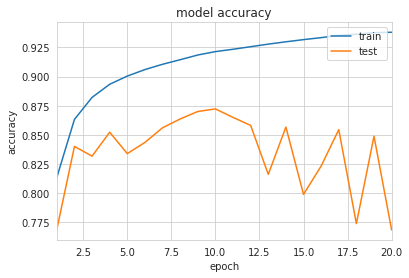

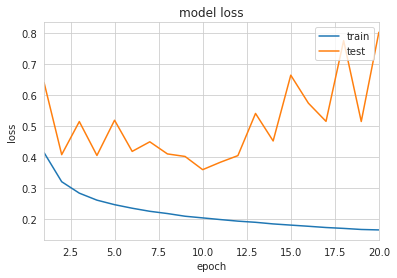

In [189]:
dim = np.arange(1, len(hist.history['accuracy']) + 1)
plt.figure()
plt.xlim(1, len(hist.history['accuracy']))
plt.plot(dim, hist.history['accuracy'])
plt.plot(dim, hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.figure()
plt.xlim(1, len(hist.history['accuracy']))
plt.plot(dim, hist.history['loss'])
plt.plot(dim, hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [190]:
# Code below from https://www.kaggle.com/georsara1/95-auc-score-in-train-sample-with-neural-nets

#Predict on test set
predictions_NN_prob = best_model.predict(test_pipeline)
predictions_NN_prob = predictions_NN_prob[:,1]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])

#Print accuracy
acc_NN = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.864501953125


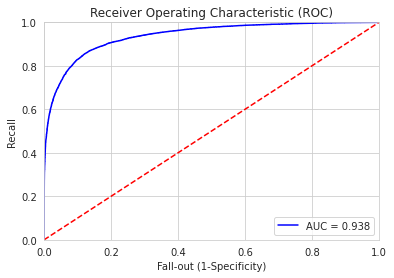

In [191]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

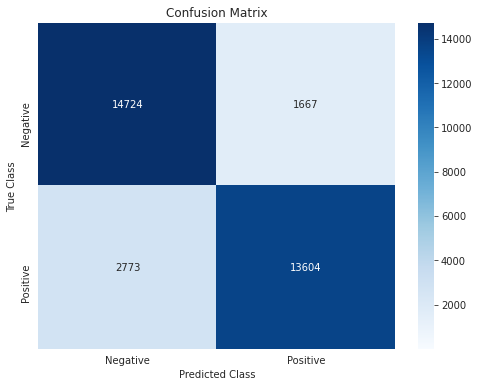

In [192]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()